Cargando anotaciones desde: C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset\annotations.csv
Total de 4886 bounding boxes válidas cargadas para clustering.

Ejecutando K-means para encontrar 9 anchor boxes...
Iniciando K-means con 9 centroides iniciales:
[[ 98.  59.]
 [ 71.  77.]
 [116.  89.]
 [106.  83.]
 [128. 131.]
 [108. 101.]
 [104.  99.]
 [126.  73.]
 [ 34.  39.]]


Ejecutando K-means:  25%|██▍       | 74/300 [07:08<21:48,  5.79s/it]

K-means convergió en la iteración 75.

--- Anchor Boxes Calculadas (Formato para YOLOv3Loss) ---
[[(227, 210), (179, 155), (124, 111)], [(105, 113), (104, 96), (80, 109)], [(112, 75), (87, 82), (39, 38)]]



IoU promedio de clustering: 0.8765

Guarda estas anchor boxes para usarlas en la instanciación de tu modelo YOLOv3 y tu función de pérdida.


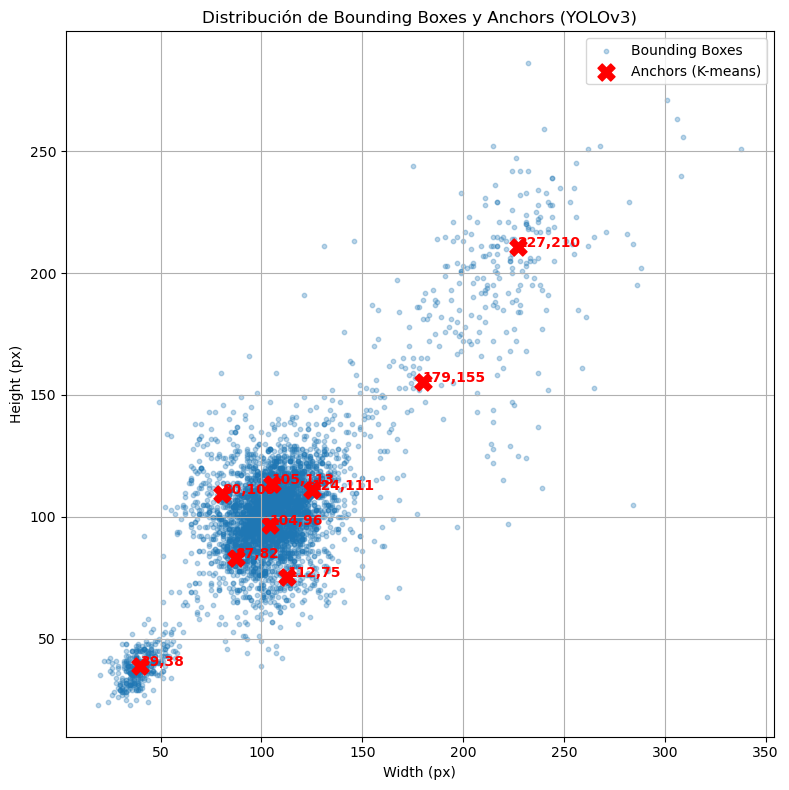

In [1]:
# Calcula anchor boxes para YOLOv3 usando K-means con IoU como métrica de distancia.
# Basado en el artículo de https://arxiv.org/abs/1506.01497 y la implementación de YoloV3 en PyTorch.

import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# --- Definición de la función IoU ---
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    else:
        raise ValueError("box_format debe ser 'midpoint' o 'corners'")

    x1_inter = torch.max(box1_x1, box2_x1)
    y1_inter = torch.max(box1_y1, box2_y1)
    x2_inter = torch.min(box1_x2, box2_x2)
    y2_inter = torch.min(box1_y2, box2_y2)

    intersection = (x2_inter - x1_inter).clamp(0) * (y2_inter - y1_inter).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    union = box1_area + box2_area - intersection + 1e-6
    iou = intersection / union
    return iou

def iou_distance(box, centroid):
    box_tensor = torch.tensor([[0.0, 0.0, box[0], box[1]]], dtype=torch.float32)
    centroid_tensor = torch.tensor([[0.0, 0.0, centroid[0], centroid[1]]], dtype=torch.float32)
    iou = intersection_over_union(box_tensor, centroid_tensor, box_format="corners").item()
    return 1 - iou

def calculate_average_iou(boxes, centroids):
    total_iou = 0.0
    num_boxes = 0
    for box in boxes:
        best_iou = -1
        for centroid in centroids:
            iou = 1 - iou_distance(box, centroid)
            if iou > best_iou:
                best_iou = iou
        total_iou += best_iou
        num_boxes += 1
    return total_iou / num_boxes if num_boxes > 0 else 0.0

# --- K-means con numpy optimizado en la asignación ---
def kmeans_iou(boxes, k, max_iters=100, tol=1e-6, random_seed=42):
    random.seed(random_seed)
    centroids = np.array(random.sample(list(boxes), k)).astype(np.float32)
    print(f"Iniciando K-means con {k} centroides iniciales:")
    print(centroids)

    for iteration in tqdm(range(max_iters), desc="Ejecutando K-means"):
        # Vectorized assignment: calcula 1-IoU de todas las cajas a todos los centroides
        clusters = [[] for _ in range(k)]
        boxes_exp = np.expand_dims(boxes, axis=1)  # (N, 1, 2)
        centroids_exp = np.expand_dims(centroids, axis=0)  # (1, k, 2)
        distances = np.zeros((boxes.shape[0], k))
        for i in range(k):
            dists = []
            for box in boxes:
                dists.append(iou_distance(box, centroids[i]))
            distances[:, i] = dists
        closest = np.argmin(distances, axis=1)
        for idx, cluster_idx in enumerate(closest):
            clusters[cluster_idx].append(boxes[idx])

        new_centroids = np.zeros_like(centroids)
        for i, cluster in enumerate(clusters):
            if cluster:
                new_centroids[i] = np.mean(cluster, axis=0)
            else:
                new_centroids[i] = random.choice(list(boxes))

        max_centroid_shift = 0.0
        for i in range(k):
            shift = iou_distance(centroids[i], new_centroids[i])
            if shift > max_centroid_shift:
                max_centroid_shift = shift
        centroids = new_centroids

        if max_centroid_shift < tol:
            print(f"K-means convergió en la iteración {iteration + 1}.")
            break
    else:
        print(f"K-means alcanzó el número máximo de iteraciones ({max_iters}) sin converger con la tolerancia {tol}.")

    return centroids

# --- Main ---
if __name__ == "__main__":
    DATA_ROOT = 'C:/Users/gtoma/Master_AI_Aplicada/GitHubRep/PyTorch-YOLOv3/dataset'
    CSV_FILE = os.path.join(DATA_ROOT, 'annotations.csv')
    NUM_ANCHORS = 9

    print(f"Cargando anotaciones desde: {CSV_FILE}")
    try:
        annotations_df = pd.read_csv(CSV_FILE)
        annotations_df = annotations_df.dropna(subset=['xmin', 'ymin', 'xmax', 'ymax'])
        annotations_df[['xmin', 'ymin', 'xmax', 'ymax']] = annotations_df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
    except FileNotFoundError:
        print(f"Error: Archivo CSV no encontrado en {CSV_FILE}")
        exit()

    annotations_df['width'] = annotations_df['xmax'] - annotations_df['xmin']
    annotations_df['height'] = annotations_df['ymax'] - annotations_df['ymin']
    filtered_boxes = annotations_df[(annotations_df['width'] > 0) & (annotations_df['height'] > 0)]
    all_box_dimensions = filtered_boxes[['width', 'height']].values.astype(np.float32)

    if len(all_box_dimensions) == 0:
        print("No se encontraron bounding boxes válidas para el clustering. Revisa tu CSV y filtros.")
        exit()

    print(f"Total de {len(all_box_dimensions)} bounding boxes válidas cargadas para clustering.\n")

    print(f"Ejecutando K-means para encontrar {NUM_ANCHORS} anchor boxes...")
    anchor_centroids = kmeans_iou(all_box_dimensions, k=NUM_ANCHORS, max_iters=300, tol=1e-5)

    anchor_centroids = anchor_centroids[np.argsort(anchor_centroids[:, 0] * anchor_centroids[:, 1])]
    anchor_centroids = anchor_centroids[::-1]

    sorted_anchors = []
    for anchor in anchor_centroids:
        sorted_anchors.append(tuple(anchor.round(2).astype(int)))
    final_anchors = [
        sorted_anchors[0:3],
        sorted_anchors[3:6],
        sorted_anchors[6:9],
    ]

    print("\n--- Anchor Boxes Calculadas (Formato para YOLOv3Loss) ---")
    print(final_anchors)

    average_iou = calculate_average_iou(all_box_dimensions, anchor_centroids)
    print(f"\nIoU promedio de clustering: {average_iou:.4f}")

    print("\nGuarda estas anchor boxes para usarlas en la instanciación de tu modelo YOLOv3 y tu función de pérdida.")

    # --- Visualización: scatter plot de cajas y anchors ---
    plt.figure(figsize=(8, 8))
    plt.scatter(all_box_dimensions[:, 0], all_box_dimensions[:, 1], s=10, alpha=0.3, label="Bounding Boxes")
    anchor_ws = anchor_centroids[:, 0]
    anchor_hs = anchor_centroids[:, 1]
    plt.scatter(anchor_ws, anchor_hs, c='red', s=150, marker='X', label="Anchors (K-means)")
    for i, (w, h) in enumerate(zip(anchor_ws, anchor_hs)):
        plt.text(w, h, f"{int(w)},{int(h)}", color="red", fontsize=10, fontweight='bold')
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.title("Distribución de Bounding Boxes y Anchors (YOLOv3)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

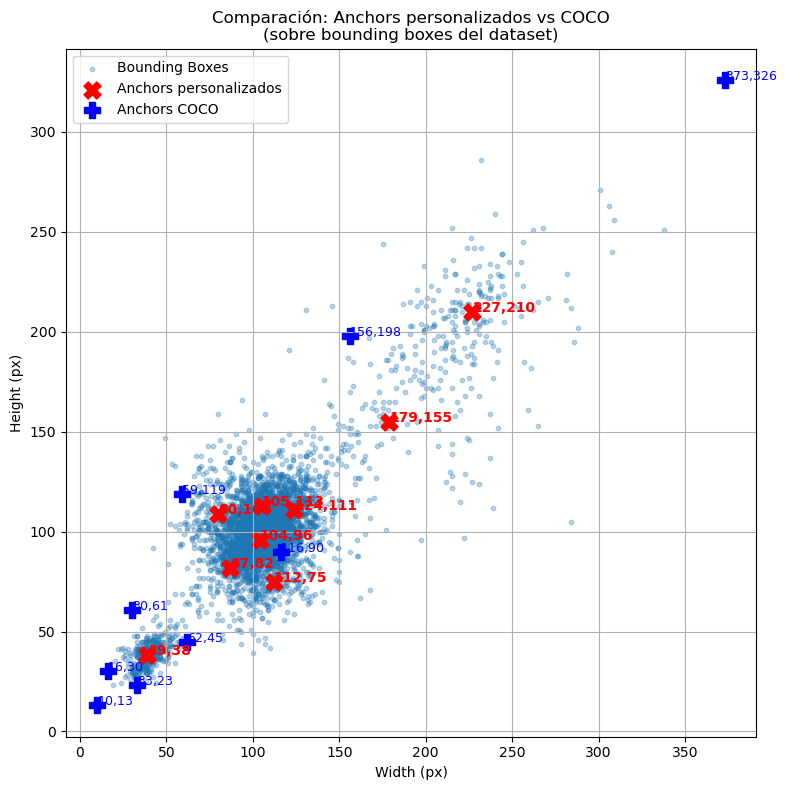

In [2]:
# Compara tus anchors con los de COCO
import matplotlib.pyplot as plt

# --- Anchors estándar de COCO para 416x416 (puedes ajustar si quieres otra resolución) ---
coco_anchors = [
    (10, 13), (16, 30), (33, 23),
    (30, 61), (62, 45), (59, 119),
    (116, 90), (156, 198), (373, 326)
]
# Ordenar igual que en tu pipeline, de mayor a menor área
coco_anchors = sorted(coco_anchors, key=lambda wh: wh[0]*wh[1], reverse=True)
coco_anchors = np.array(coco_anchors)

# --- Tus anchors personalizados ---
custom_anchors = np.array([a for group in final_anchors for a in group])  # ya están ordenados

plt.figure(figsize=(8, 8))
# Nube de bounding boxes reales
plt.scatter(all_box_dimensions[:, 0], all_box_dimensions[:, 1], s=10, alpha=0.3, label="Bounding Boxes")

# Anchors personalizados
plt.scatter(custom_anchors[:, 0], custom_anchors[:, 1], c='red', s=150, marker='X', label="Anchors personalizados")
for w, h in custom_anchors:
    plt.text(w, h, f"{int(w)},{int(h)}", color="red", fontsize=10, fontweight='bold')

# Anchors COCO
plt.scatter(coco_anchors[:, 0], coco_anchors[:, 1], c='blue', s=120, marker='P', label="Anchors COCO")
for w, h in coco_anchors:
    plt.text(w, h, f"{int(w)},{int(h)}", color="blue", fontsize=9)

plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Comparación: Anchors personalizados vs COCO\n(sobre bounding boxes del dataset)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()